# DATA3800-1 23H Introduction to Data Science with Scripting

# Is it possible to accurately classify a person as being diabetic, prediabetic or non-diabetic based upon survey responses?


## Abstract

Diabetes is a life-threatening disease which places a significant burden on the healthcare system as well as on patients. The early detection of prediabetes could play a vital role in reducing the prevalence of diabetes, but in the US, figures show an alarming percentage of those living with the disease are undiagnosed. In a country where healthcare is prohibitively expensive for many, a survey-based method of screening could provide a quick and free way of identifying those with or at risk of developing the disease.

Working with a selected subset of data from the BRFSS 2015 health survey, I attempted to identify diabetics/prediabetics using just the subjective information supplied. The inherent uncertainty in the diabetes labels meant that I had to perform cluster analysis rather than data classification, and I looked at different methods of trying to optimise the quality of clusters, which is necessary for further patient demographic analysis.

The results were inconclusive: The cluster analysis revealed the likely presence of two clusters, but the quality was insufficient to proceed with random forest regression, which would have provided more information about feature importance for the clusters. In my conclusion I discuss alternative methods which may yield more helpful results.

## Introduction

### What is diabetes?

Diabetes is a chronic disease that occurs when the pancreas does not produce enough insulin or when the body is not able to use the insulin it produces. There are two types of diabetes:

1.   **Type 1 diabetes**: The pancreas does not make insulin because the body’s immune system attacks the cells in the pancreas where insulin is made. People with type 1 diabetes require daily administration of insulin. This type of diabetes is thought to be largely attributed to genetics and environmental factors.

2.   **Type 2 diabetes**: The pancreas makes less insulin than used to, and the body becomes immune to the effects. The body has insulin; however, it is not able to use it. Type 2 diabetes is the most common form of the disease, and genetics and lifestyle are both risk factors.

Prediabetes describes a condition in which blood sugar levels are higher than normal but not high enough to be classified as type 2 diabetes. It is an intermediate stage and is a warning sign that a person is at increased risk of developing type 2 diabetes (Symptoms & Causes of Diabetes - NIDDK, n.d.).


### Research question

In the US, a total of 38.4 million people have diabetes, a figure representing 11.6% of the population (National Diabetes Statistics Report, 2023). Of these, an estimated 8.7 million - over 20% - are undiagnosed. At the same time, 97.6 million adults - more than 1 in 3 of the population - have prediabetes, and 80% are unaware of their condition. Prediabetes is reversible, meaning that with appropriate intervention at an early stage, patients can avoid developing full diabetes and all the health risks this entails. The worst effects of diabetes include heart disease, stroke, blindness, kidney failure, amputation and even death.

The identification of undiagnosed prediabetics would be particularly useful, as this condition is fully reversible; early diagnosis would be a golden opportunity to reach this demographic and provide assistance in making lifestyle changes that may help halt or slow down the prevalence of diabetes. I wondered if it would be possible to develop a questionnaire-based tool which could identify prediabetics and diabetics without the need for clinical data. The benefits of achieving this are numerous: It would allow us to screen for the disease in a cost- and resource-efficient way, help reduce workload for healthcare providers, and be accessible to everyone, regardless of income and insurance status.

The aim of this project is to use the data from the Behavioral Risk Factor Surveillance System (BFRSS) survey to see if subjective data collected on various health-related issues reveals patterns and correlations that may serve as predictive markers for diabetes and/or prediabetes.

### BRFSS survey

The Behavioral Risk Factor Surveillance System (BRFSS) is a annual telephone survey conducted in the US by the Centers for Disease Control and Prevention (CDC) that collects data on a wide array of health-related topics, including lifestyle habits, physical and mental health, and access to healthcare.

By collecting and analyzing this data, the BRFSS plays a pivotal role in providing a comprehensive understanding of the prevalence of risk factors associated with chronic diseases and the overall health status of the population, thereby informing public health policies and interventions (About BRFSS, n.d.).

### Overview

The reminder of this project is organized as follows:   
The Theory section will provide the necessary background information about the dataset itself and the methodology behind the machine learning techniques used. In the Method section, I detail the steps taken to extract, preprocess and analyse the data from the BRFSS survey. Results and Discussion will showcase the findings and interpret them, and in the Conclusion I summarize the key takeaways from the project. Finally, in Future Work I discuss potential areas for further development and exploration which could yield better results.

### Install and import necessary frameworks

In [1]:
# For clustering algorithm

!pip install -q kmodes

In [2]:
# For MCA

!pip install -q prince

In [3]:
# For phi k analysis

!pip install phik


In [4]:
# For exporting as PDF

!pip install -q Pyppeteer
!pyppeteer-install -q

chromium is already installed.


In [2]:
%matplotlib inline

# imports for data preprocessing
import numpy as np
import pandas as pd

# imports for clustering
from kmodes.kmodes import KModes

# imports for MCA (dimensionality reduction)
import prince

# imports for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.io as pio
pio.renderers.default='notebook'
from mpl_toolkits.mplot3d import Axes3D

# imports for statistical metrics
from sklearn.metrics import silhouette_score
from scipy.stats import mode, chi2_contingency
from scipy.spatial import distance
import phik
from phik.report import plot_correlation_matrix


### Importing the dataset

My source of data was a cleaned and consolidated dataset created by Kaggle user Alex Taboul (Diabetes Health Indicators Dataset, 2023) from original survey data collected by BRFSS in 2015. The data was already in good shape, with no missing values and features reduced from 330 to 21, but I consulted the codebook for the survey (BRFSS 2015 Codebook Report, 2016) to ensure that I had the most appropriate features.

Recent studies (Ford & Robitaille, 2023) indicate that there may be links between marital status and blood sugar levels, so I felt that marital status could be a useful feature to include in our study. Likewise, the CDC considers race an important risk factor (Diabetes Risk Factors, n.d.), so this was another feature that I wanted to include. Finally, I noted that the subset contained a question about physical activity with a yes/no answer, while the original survey also had a question about physical activity which had the possible to answer with a range of ordinal values, and I felt that this contained more useful information. I therefore replaced the binary feature with the more descriptive ordinal feature. 

<div class="alert alert-block alert-info">
<b>Note:</b> The final dataset is available from <a href="https://www.kaggle.com/code/hakonem/diabetes-health-indicators-dataset-notebook/notebook">Diabetes Health Indicators Dataset Notebook, 2023</a>. The notebook also shows how the changes described above were executed.</div>


In [3]:
# Read csv file to empty dataframe
df = pd.read_csv('diabetes_012_health_indicators_BRFSS2015.csv')

In [7]:
# See the dimensions of the dataframe
df.shape

(245352, 24)

The dataset is large, with 24 features and 245,352 observations. This is computationally expensive, so I will be working with a subset of 60,000 observations which will be selected at random from the dataset. I'll set a random_state to ensure reproducibility. 

In [4]:
# Create subset
df = df.sample(60000, random_state = 42)
df

Diabetes_012  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
157728           0.0     1.0       1.0        1.0  31.0     1.0     0.0   
232552           0.0     1.0       0.0        1.0  30.0     1.0     0.0   
4095             0.0     0.0       1.0        1.0  30.0     0.0     0.0   
153151           2.0     0.0       0.0        1.0  30.0     0.0     0.0   
191600           0.0     0.0       0.0        1.0  23.0     0.0     0.0   
...              ...     ...       ...        ...   ...     ...     ...   
62921            0.0     0.0       1.0        1.0  27.0     1.0     0.0   
171417           0.0     1.0       0.0        0.0  20.0     1.0     1.0   
158942           0.0     0.0       0.0        1.0  28.0     0.0     0.0   
193290           0.0     0.0       0.0        1.0  26.0     0.0     0.0   
78557            0.0     0.0       1.0        1.0  29.0     1.0     0.0   

        HeartProbs  PhysActivity  Fruits  ...  GenHlth  MentHlth  PhysHlth  \
157728         0.0           3.0     1.0  ...      3.0       0.0       0.0   
232552         0.0           1.0     0.0  ...      2.0       0.0       0.0   
4095           1.0           4.0     0.0  ...      4.0       0.0      15.0   
153151         0.0           3.0     1.0  ...      3.0       2.0       5.0   
191600         0.0           3.0     1.0  ...      1.0       0.0       0.0   
...            ...           ...     ...  ...      ...       ...       ...   
62921          0.0           3.0     1.0  ...      1.0       0.0       0.0   
171417         0.0           1.0     0.0  ...      5.0      10.0       5.0   
158942         0.0           1.0     1.0  ...      2.0       0.0       0.0   
193290         0.0           1.0     1.0  ...      3.0       0.0      30.0   
78557          1.0           4.0     1.0  ...      4.0      25.0      23.0   

        DiffWalk  Sex   Age  Education  Income  MaritalStatus  Race  
157728       0.0  1.0   5.0        4.0     8.0            1.0   1.0  
232552       0.0  0.0   6.0        4.0     7.0            1.0   1.0  
4095         1.0  0.0  13.0        4.0     5.0            1.0   1.0  
153151       0.0  0.0   7.0        4.0     4.0            5.0   2.0  
191600       0.0  0.0   9.0        6.0     8.0            1.0   1.0  
...          ...  ...   ...        ...     ...            ...   ...  
62921        0.0  0.0   8.0        5.0     8.0            1.0   1.0  
171417       1.0  1.0  11.0        4.0     4.0            3.0   1.0  
158942       0.0  0.0   8.0        6.0     8.0            1.0   1.0  
193290       0.0  1.0   7.0        4.0     8.0            4.0   1.0  
78557        1.0  0.0   7.0        5.0     1.0            2.0   1.0  

[60000 rows x 24 columns]

## Theory

The dataset is comprised of 15 nominal features (of which 13 are binary), 5 ordinal features and 3 numerical features. The target feature ('Diabetes_012') is nominal and represents if a person is diabetic, prediabetic or non-diabetic.

In the Introduction, I reported that the CDC estimates that around 11% of population of US has diabetes, with around 1 in 5 unaware of their condition, and over one third of US adults has prediabetes, of which 8 in 10 are unaware.

Let's compare the frequency of these conditions within our dataset with the national figures:

In [9]:
# Value splits for Diabetes column as percentages of total dataset
print('\nValue counts:')
print(df['Diabetes_012'].value_counts())
print('\nAs percentages:')
print(df['Diabetes_012'].value_counts(normalize=True)*100)


Value counts:
0.0    50565
2.0     8369
1.0     1066
Name: Diabetes_012, dtype: int64

As percentages:
0.0    84.275000
2.0    13.948333
1.0     1.776667
Name: Diabetes_012, dtype: float64


Of the 60000 individuals in the our dataset, 84% reported never having been diagnosed with diabetes (no diabetes is indicated by the value 0.0), but if the CDC's estimate is to be believed, then there is a large number of people in this category who are actually wrongly labelled. The number of diagnosed prediabetics (indicated by the value 1.0) is very low at less than 2% of the sample, and we believe the true number is much higher.

The initial plan was to see if I could use the features in this dataset to predict the corresponding label. This is a straightforward classification problem which could be solved using logistic regression. However, the whole premise of the investigation is that a large percentage of diabetics/prediabetics are unaware of their condition. This means that we cannot be certain that everyone who has self-reported their diabetes status as ‘non-diabetic’ is correct – in other words, we don’t have ground truth.

So I decided to approach the problem in a different way: dropping the Diabetes_012 column and just using the feature variables in a clustering model. This becomes an unsupervised problem, and instead of predicting a label for each observation, the aim is to explore the data to see if cluster analysis can reveal patterns in the data which might identify a person as being diabetic or not. 


### The clustering model


There are many different methods for clustering, and the one chosen must be suitable for the types of data in the dataset. Numerical data may need to be normalised/scaled, dependent on whether or not the algorithm used assumes normal distribution. Also, different statistical tests must be used depending on the datatypes of the features in the dataset.

Most clustering algorithms work on numeric data. For example, K-Means uses Euclidean distance between data points to place them into the relevant clusters, and uses means to update centroids. It's not possible to find the mean of categorical data, so most of these methods will not work on my dataset. **K-modes** is a possible solution, though. Similar data points are organised into clusters based on how similar the properties of the data points are, and the centres of these clusters are updates iteratively using modes (Guide & Bonthu, 2023).

The algorithm works like this:

1.   Pick K observations and assign them as cluster centroids i.e. The values for the various feature variables will become the features for each of the clusters.
2.   We iterate through each of the remaining observations in the dataset. For each observation, we compare each of its features with those of each cluster centroid and give a score of 1 for each dissimilarity. The scores are added up for each cluster and the observation is assigned to the cluster with the lowest score (i.e. the cluster it is most similar to).
3.   Once all the observations have been assigned, we look at each cluster in turn. For each feature in that cluster, we find the mode; that value then becomes the new feature value for that cluster.
4.   Repeat 2–3 steps until no further reassignment is required.

I will use the **elbow method** to establish the optimal number of clusters for the dataset, and I will confirm the results by finding the **silhouette score**. 

The elbow method is used to help finding the optimal number of clusters _k_ in a dataset. The method works by performing clustering for different values of _k_, then, for each _k_, calculating the sum of squared distances from each point to its assigned centre. When these values are plotted, we look for the “elbow” (the first noticeable sharp bend) where the rate decrease slows down. This point is considered a good estimate for the optimal number of clusters, as adding more clusters beyond this point would not significantly reduce the overall sum of squared distances. By identifying the optimal number of clusters, you make sure that the model does not overfit. Choosing too many clusters can lead to a model that does not work well on new data since it has been trained too closely on the training set, including the noise and fluctuations (Jain, 2023).

The silhouette score is a measurement of how well-defined and separated the clusters are. The score ranges from -1 to 1. A high score indicates that the object is well matched to its own clusters and poorly matched to neighbouring clusters. A score near 0 indicate overlapping clusters. A low score indicates that the object is poorly matched to its own clusters or may be in a dense region of points that is not well separated from other clusters. To obtain the silhouette score for a sample, you need to measure two values for each data point. The first value, _a_, is the average distance from the point to the other points in the same cluster. The second value, _b_, is the average distance from the point to the points in the nearest cluster that the point is not a part of. The silhouette score is calculated thus: _b_ - _a_/max(_a_,_b_). Scores are averaged for all data points in the sample to achieve one overall score for the cluster (Joshi, 2021).

These methods will hopefully suggest that three distinct groups can be found, which means the algorithm has detected significant similarities between the data points in these groups, at the same time as the groups are well-defined and distinguishable from each other.

Another method that I plan to use in this project is **Multiple Correspondence Analysis (MCA)**. MCA is a dimensionality reduction technique suitable for use with categorical data, similar to how PCA is used with numerical data. It works by transforming the original data into a new set of independent vectors that simplify the relationships between the original features (Multiple Correspondence Analysis, n.d.; Khoong, 2023). The new vectors represent almost the same amount of information as the original data set, but in a lower dimensional space. This means that MCA can be used to visualise high-dimensional datasets (i.e. datasets with lots of columns/features) in 1D, 2D or 3D. 

### Preprocessing the data

In [5]:
# Dropping the target column

df = df.drop(columns=['Diabetes_012'], axis=1)

df

HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  HeartProbs  \
157728     1.0       1.0        1.0  31.0     1.0     0.0         0.0   
232552     1.0       0.0        1.0  30.0     1.0     0.0         0.0   
4095       0.0       1.0        1.0  30.0     0.0     0.0         1.0   
153151     0.0       0.0        1.0  30.0     0.0     0.0         0.0   
191600     0.0       0.0        1.0  23.0     0.0     0.0         0.0   
...        ...       ...        ...   ...     ...     ...         ...   
62921      0.0       1.0        1.0  27.0     1.0     0.0         0.0   
171417     1.0       0.0        0.0  20.0     1.0     1.0         0.0   
158942     0.0       0.0        1.0  28.0     0.0     0.0         0.0   
193290     0.0       0.0        1.0  26.0     0.0     0.0         0.0   
78557      0.0       1.0        1.0  29.0     1.0     0.0         1.0   

        PhysActivity  Fruits  Veggies  ...  GenHlth  MentHlth  PhysHlth  \
157728           3.0     1.0      0.0  ...      3.0       0.0       0.0   
232552           1.0     0.0      1.0  ...      2.0       0.0       0.0   
4095             4.0     0.0      1.0  ...      4.0       0.0      15.0   
153151           3.0     1.0      0.0  ...      3.0       2.0       5.0   
191600           3.0     1.0      1.0  ...      1.0       0.0       0.0   
...              ...     ...      ...  ...      ...       ...       ...   
62921            3.0     1.0      1.0  ...      1.0       0.0       0.0   
171417           1.0     0.0      0.0  ...      5.0      10.0       5.0   
158942           1.0     1.0      1.0  ...      2.0       0.0       0.0   
193290           1.0     1.0      1.0  ...      3.0       0.0      30.0   
78557            4.0     1.0      1.0  ...      4.0      25.0      23.0   

        DiffWalk  Sex   Age  Education  Income  MaritalStatus  Race  
157728       0.0  1.0   5.0        4.0     8.0            1.0   1.0  
232552       0.0  0.0   6.0        4.0     7.0            1.0   1.0  
4095         1.0  0.0  13.0        4.0     5.0            1.0   1.0  
153151       0.0  0.0   7.0        4.0     4.0            5.0   2.0  
191600       0.0  0.0   9.0        6.0     8.0            1.0   1.0  
...          ...  ...   ...        ...     ...            ...   ...  
62921        0.0  0.0   8.0        5.0     8.0            1.0   1.0  
171417       1.0  1.0  11.0        4.0     4.0            3.0   1.0  
158942       0.0  0.0   8.0        6.0     8.0            1.0   1.0  
193290       0.0  1.0   7.0        4.0     8.0            4.0   1.0  
78557        1.0  0.0   7.0        5.0     1.0            2.0   1.0  

[60000 rows x 23 columns]

Table 1 lists all the features found in the dataset by column name (feature name), explains if necessary the survey question relating to the feature, and describes what type of data the feature is and the range of values within each feature. 

**TABLE 1: An overview of the features selected for our study and their properties** 

<table>
    <tr>
        <th>Feature name</th>
        <th>Description</th>
        <th>Datatype</th>
        <th>Values</th>
    </tr>
    <tr>
        <td>Diabetes_012</td>
        <td>Ever told you have diabetes?</td>
        <td>Nominal</td>
        <td>2 = Diabetic, 1 = Pre-diabetic, 0 = Non-diabetic</td>
    </tr>
    <tr>
        <td>HighBP</td>
        <td>Ever Told Blood Pressure High?</td>
        <td>Nominal (binary)</td>
        <td>1 = Yes, 0 = No</td>
    </tr>
    <tr>
        <td>HighChol</td>
        <td>Ever Told Blood Cholesterol High?</td>
        <td>Nominal (binary)</td>
        <td>1 = Yes, 0 = No</td>
    </tr>
    <tr>
        <td>CholCheck</td>
        <td>Cholesterol check within past five years?</td>
        <td>Nominal (binary)</td>
        <td>1 = Yes, 0 = No</td>
    </tr>
    <tr>
        <td>BMI</td>
        <td>This is an engineered feature calculated from reported height and weight of each respondent</td>
        <td>Ratio</td>
        <td>Values in range 12.0-98.0</td>
    </tr>
    <tr>
        <td>Smoker</td>
        <td>Have you smoked at least 100 cigarettes in your entire life?</td>
        <td>Nominal (binary)</td>
        <td>1 = Yes, 0 = No</td>
    </tr>
    <tr>
        <td>Stroke</td>
        <td>Ever told you had a stroke?</td>
        <td>Nominal (binary)</td>
        <td>1 = Yes, 0 = No</td>
    </tr>
    <tr>
        <td>HeartProbs</td>
        <td>Ever diagnosed with coronary heart disease (CHD) or myocardial infarction (MI)?</td>
        <td>Nominal (binary)</td>
        <td>1 = Yes, 0 = No</td>
    </tr>
    <tr>
        <td>PhysActivity</td>
        <td>Reported activity levels of individuals</td>
        <td>Ordinal</td>
        <td>1 = Highly active, 2 = Active, 3 = Insufficiently active, 4 = Inactive</td>
    </tr>
    <tr>
        <td>Fruits</td>
        <td>Consume fruit 1 or more times per day?</td>
        <td>Nominal (binary)</td>
        <td>1 = Yes, 0 = No</td>
    </tr>
    <tr>
        <td>Veggies</td>
        <td>Consume vegetables 1 or more times per day?</td>
        <td>Nominal (binary)</td>
        <td>1 = Yes, 0 = No</td>
    </tr>
    <tr>
        <td>HvyAlcoholConsump</td>
        <td>Heavy drinkers? (adult men having more than 14 drinks per week and adult women having more than 7 drinks per week)</td>
        <td>Nominal (binary)</td>
        <td>1 = Yes, 0 = No</td>
    </tr>
    <tr>
        <td>AnyHealthcare</td>
        <td>Any kind of health care coverage, including health insurance, prepaid plans such as HMOs, or government plans such as Medicare, or Indian Health Service?</td>
        <td>Nominal (binary)</td>
        <td>1 = Yes, 0 = No</td>
    </tr>
    <tr>
        <td>NoDocbcCost</td>
        <td>Was there a time in the past 12 months when you needed to see a doctor but could not because of cost?</td>
        <td>Nominal (binary)</td>
        <td>1 = Yes, 0 = No</td>
    </tr>
    <tr>
        <td>GeneralHlth</td>
        <td>Reported general health</td>
        <td>Ordinal</td>
        <td>Scale of 1-5: 1 = Excellent -> 5 = Poor</td>
    </tr>
    <tr>
        <td>MentHlth</td>
        <td>Respondents reported for how many days during the past 30 days was their mental health not good (including stress, depression, and problems with emotions)</td>
        <td>Ratio</td>
        <td>Values in range 0.0-30.0</td>
    </tr>
    <tr>
        <td>PhysHlth</td>
        <td>Respondents reported for how many days during the past 30 days was their physical health not good </td>
        <td>Ratio</td>
        <td>Values in range 0.0-30.0</td>
    </tr>
    <tr>
        <td>DiffWalk</td>
        <td>Serious difficulty walking or climbing stairs?</td>
        <td>Nominal (binary)</td>
        <td>1 = Yes, 0 = No</td>
    </tr>
    <tr>
        <td>Sex</td>
        <td></td>
        <td>Nominal (binary)</td>
        <td>1 = Male, 0 = Female</td>
    </tr>
    <tr>
        <td>Age</td>
        <td></td>
        <td>Ordinal</td>
        <td>Age is grouped in 5-year increments, where 1 = 18-24 -> 13 = 80 and older</td>
    </tr>
    <tr>
        <td>Education</td>
        <td>Highest grade or year of school completed</td>
        <td>Ordinal</td>
        <td>1 = never attended school or kindergarten only -> 6 = 4 years or more at college</td>
    </tr>
    <tr>
        <td>Income</td>
        <td></td>
        <td>Ordinal</td>
        <td>1 = less than \$10,000 -> 8 = \$75,000 or more</td>
    </tr>
    <tr>
        <td>MaritalStatus</td>
        <td></td>
        <td>Nominal</td>
        <td>1 = married, 2 = divorced, 3 = widowed, 4 = separated, 5 = never married, 6 = unmarried couple</td>
    </tr>
    <tr>
        <td>Race</td>
        <td></td>
        <td>Nominal</td>
        <td>1 = White non-Hispanic, 2 = Black non-Hispanic, 3 = American Indian or Alaskan Native, non-Hispanic, 4 = Asian, non-Hispanic, 5 = Native Hawaiian or other Pacific Islander, non-Hispanic, 6 = Other race only, non-Hispanic, 7 = Multiracial, non-Hispanic, 8 = Hispanic
        </td>
    </tr>
    
</table>


The dataset contains just three numerical (ratio) features: BMI, MentHlth and PhysHlth. There are good reasons for converting these to categories:

*  It’s much easier to handle data that’s all of the same type.

*  BMI categories of Underweight, Normal weight, Overweight and Obese are more important for a diabetes diagnosis than the actual calculated BMI score.

*  There is another feature, GenHlth, which is an ordinal category on a scale of 1 to 5, with 1 being Excellent and 5 being Poor. There is no compelling reason why MentHlth and PhysHlth should be measured on a different scale/metric (number of sick days in the last month). These scores could be binned into 5 groups of equal size, so that the health features are scored on the same scale.

In [6]:
# BMI feature engineering
# New categories: 0.0 = Underweight, 1.0 = Normal weight, 2.0 = Overweight, 3.0 = Obese
bmi_labels = [0.0, 1.0, 2.0, 3.0]
cut_bins = [0, 18.5, 24.9, 29.9, df["BMI"].max()]
df['BMI'] = pd.cut(df['BMI'], bins=cut_bins, labels=bmi_labels)


In [7]:
# MentHlth/PhysHlth feature engineering
# We want to convert 0-30 days (continuous) to a similar scale to GenHlth
# Split each feature into 5 equal bins

df['MentHlth'] = pd.cut(df['MentHlth'], 5,
                              labels=[1.0, 2.0, 3.0, 4.0, 5.0])

df['PhysHlth'] = pd.cut(df['PhysHlth'], 5,
                              labels=[1.0, 2.0, 3.0, 4.0, 5.0])

In [24]:
# Check python datatype assignments

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60000 entries, 157728 to 78557
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   HighBP             60000 non-null  float64 
 1   HighChol           60000 non-null  float64 
 2   CholCheck          60000 non-null  float64 
 3   BMI                60000 non-null  category
 4   Smoker             60000 non-null  float64 
 5   Stroke             60000 non-null  float64 
 6   HeartProbs         60000 non-null  float64 
 7   PhysActivity       60000 non-null  float64 
 8   Fruits             60000 non-null  float64 
 9   Veggies            60000 non-null  float64 
 10  HvyAlcoholConsump  60000 non-null  float64 
 11  AnyHealthcare      60000 non-null  float64 
 12  NoDocbcCost        60000 non-null  float64 
 13  GenHlth            60000 non-null  float64 
 14  MentHlth           60000 non-null  category
 15  PhysHlth           60000 non-null  category
 16 

Having converted numerical features to categorical features, we can see that the remaining features have been assigned datatype 'float64' by Python, most likely because the values have already been encoded with numerical values. This could cause problems for any algorithms that are specifically intended to handle categorical data, and it will also increase the size of the dataframe, making computations much more time consuming. By converting all the datatypes to 'category', making sure that ordinal features are explicitly labelled as such, I can retain the inherent ranking of values when it comes to clustering.

In [8]:
# Convert ordinal features to to category (ordered)

ordinals_and_levels = {'PhysActivity': [1.0, 2.0, 3.0, 4.0],
                       'GenHlth': [1.0, 2.0, 3.0, 4.0, 5.0],
                       'Age': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0],
                       'Education': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0],
                       'Income': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
                       }

for ordinal, levels in ordinals_and_levels.items():
    df[ordinal] = pd.Categorical(df[ordinal], categories=levels, ordered=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60000 entries, 157728 to 78557
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   HighBP             60000 non-null  float64 
 1   HighChol           60000 non-null  float64 
 2   CholCheck          60000 non-null  float64 
 3   BMI                60000 non-null  category
 4   Smoker             60000 non-null  float64 
 5   Stroke             60000 non-null  float64 
 6   HeartProbs         60000 non-null  float64 
 7   PhysActivity       60000 non-null  category
 8   Fruits             60000 non-null  float64 
 9   Veggies            60000 non-null  float64 
 10  HvyAlcoholConsump  60000 non-null  float64 
 11  AnyHealthcare      60000 non-null  float64 
 12  NoDocbcCost        60000 non-null  float64 
 13  GenHlth            60000 non-null  category
 14  MentHlth           60000 non-null  category
 15  PhysHlth           60000 non-null  category
 16 

In [9]:
# Convert all nominal and binary features that currently have float64 datatype to to category (unordered)

float_features = df.select_dtypes(include=['float64']).columns

# Convert features with float64 datatype to 'category'
df[float_features] = df[float_features].apply(lambda col: col.astype('category'))

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60000 entries, 157728 to 78557
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   HighBP             60000 non-null  category
 1   HighChol           60000 non-null  category
 2   CholCheck          60000 non-null  category
 3   BMI                60000 non-null  category
 4   Smoker             60000 non-null  category
 5   Stroke             60000 non-null  category
 6   HeartProbs         60000 non-null  category
 7   PhysActivity       60000 non-null  category
 8   Fruits             60000 non-null  category
 9   Veggies            60000 non-null  category
 10  HvyAlcoholConsump  60000 non-null  category
 11  AnyHealthcare      60000 non-null  category
 12  NoDocbcCost        60000 non-null  category
 13  GenHlth            60000 non-null  category
 14  MentHlth           60000 non-null  category
 15  PhysHlth           60000 non-null  category
 16 

### Exploring the data

First I wanted to spend some time looking at the data to see if any patterns are already apparent. I started by creating bar charts for each of the features to visualise value counts and look for relationships (Figure 1). 

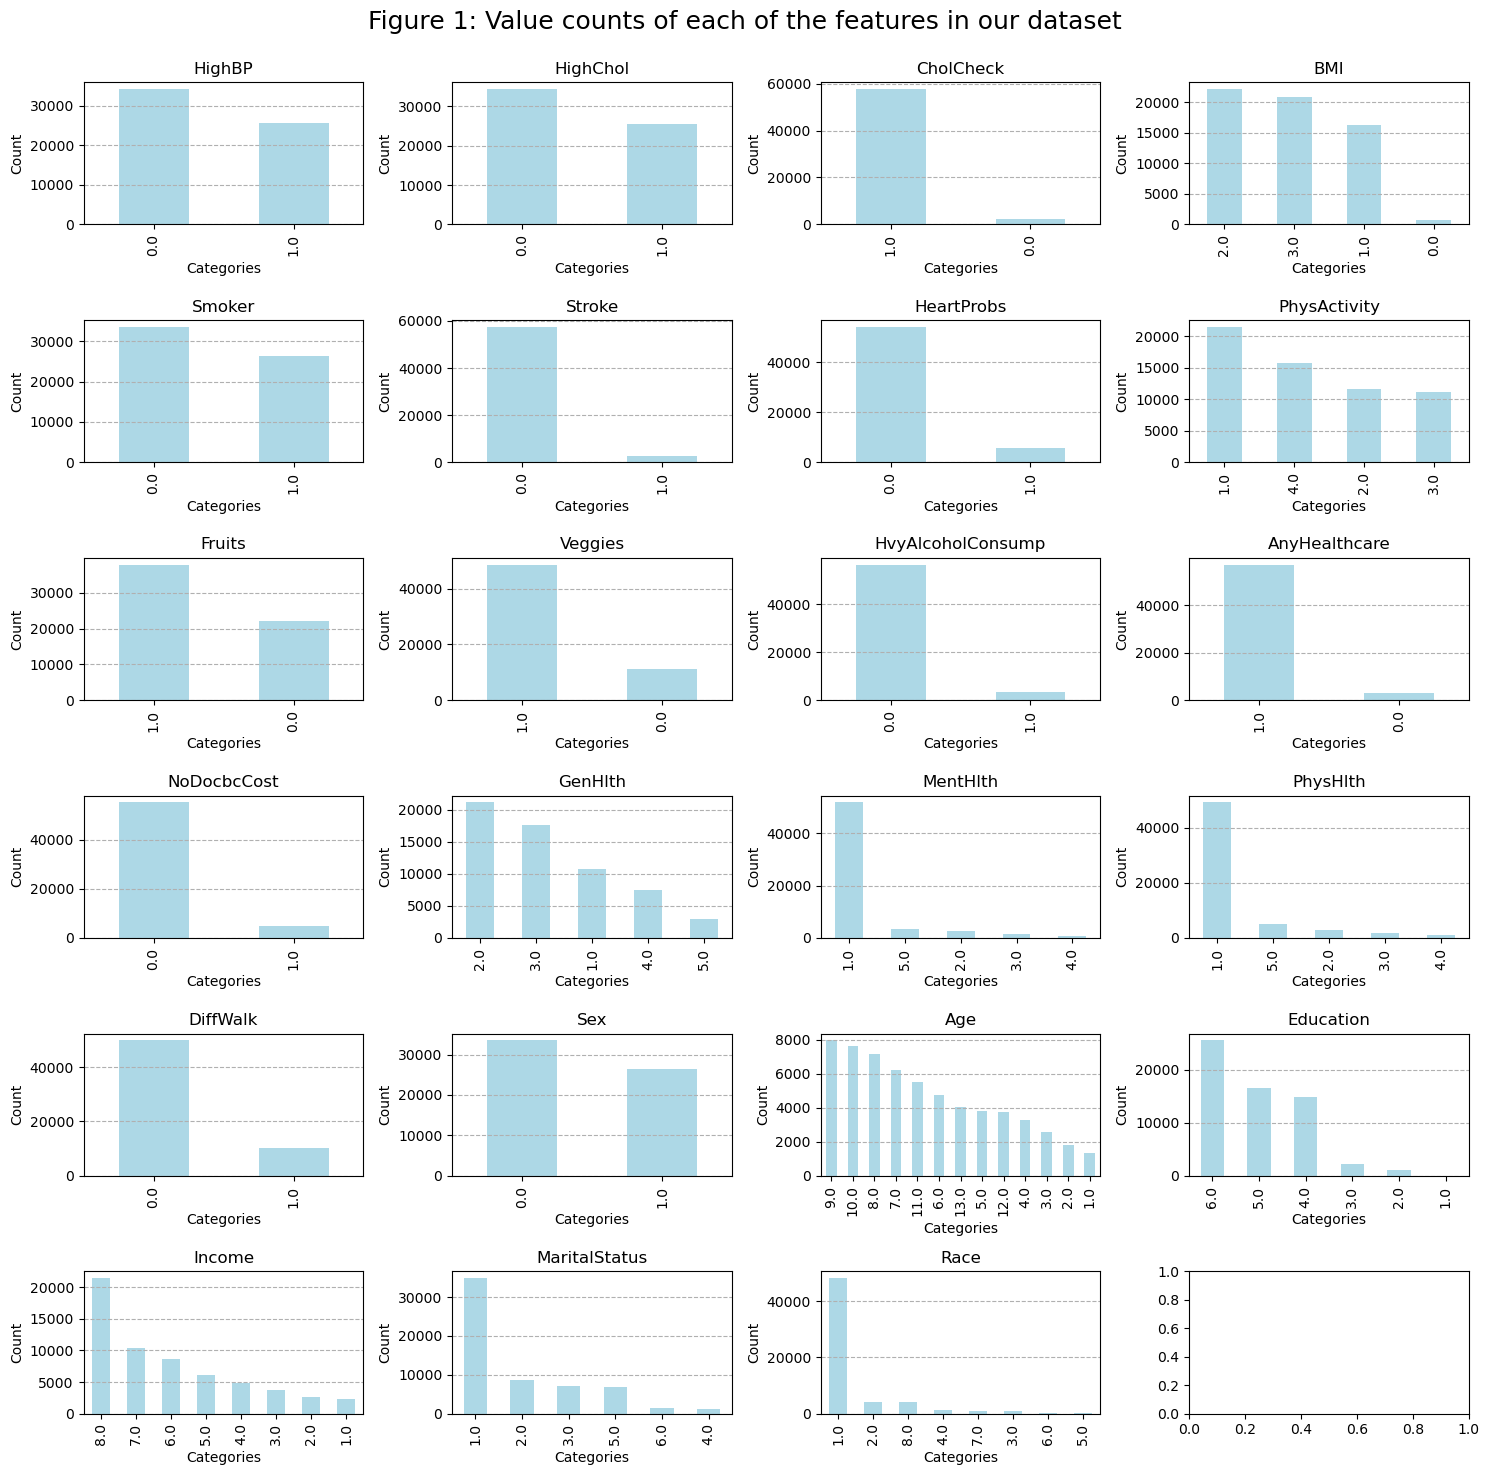

In [16]:
# Looking at the composition of each feature

fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(15, 15))

# Flatten the 2D array of axes into a 1D array
axes = axes.flatten()

# Iterate through each categorical variable and create a bar chart
for i, column in enumerate(df.columns):
    ax = axes[i]  
    df[column].value_counts().plot(kind='bar', ax=ax, color='lightblue')
    ax.set_title(column)
    ax.set_xlabel('Categories')
    ax.set_ylabel('Count')
    ax.grid(axis='y', linestyle='--')

fig.suptitle('Figure 1: Value counts of each of the features in our dataset\n', fontsize=18)
plt.tight_layout()
plt.show()

A quick look at the bar charts in Figure 1 reveal some interesting details about the values for each feature: 

*   None of the features show zero variance, but a number of them do show an overwhelming majority in one of two binary values: CholCheck, Stroke, HeartProbs, HvyAlcoholConsump, AnyHealthcare, NoDocbcCost. These could be good candidates for removal; features with low variance won't provide much discriminatory information for the clustering algorithm and will therefore contribute little to the decision-making process. Stroke and heart problems are also smoking-related conditions, so there will be some correlation between these features and Smoker.

*   Most of the observations fall within the White class under Race, with the remaining classes containing very low frequencies. It could be a good idea to combine the smaller classes into one; within the context of race, we know that White people are less at risk of type 2 diabetes than other races, so this would essentially turn the Race feature into a binary higher risk/lower risk category.

*   The charts for mental health and physical health, which were the categories we converted from ratio data, look the same, but most respondents fall into the 'excellent' category there, while most respondents in the general health category fall into the 'very good' category. This may of course be due to the conversion of data, and that the features were initially scored on different scales.

## Method

### Feature selection

Generally, the more data we have, the more information we have to feed into the algorithm, but there is such as thing as too much information. Irrelevant data can confuse the clustering algorithm into placing too much weight on unimportant features, leading to poor results, which in this case means indistinct clusters of low density. It will also produce an overly complicated algorithm that takes a long time to train. The process of selecting the subset of features which best represent the data is called feature selection.

I decided to try some different approaches to feature selection, as suggested by Jain (2020):

1.   First I will perform clustering on the entire dataset as a control, in order to observe the effects of feature selection. I will be using the KModes framework for this. Multiple correspondence analysis (MCA), which was implemented through the prince library and visualised with plotly, will allow me to reduce the dimensionality and observe the clusters in 3D.

2.   **Filter method**: Using appropriate statistical methods to calculate a score for each feature, and then comparing the scores and eliminating redundant features. Statistical methods suitable for categorical data are the chi-square test of independence (using the scipy framework) and the $phi_{k}$ coefficient (Lewinson, 2021), which was utilised through the phik library.

*Chi square test of independence*: The test determines if two variables are statistically independent or not. We start with a null hypothesis (H₀) that assumes that the two variables are independent; the alternative hypothesis (H₁) assumes that they are dependent. The chi-square test returns a p-value (calculated using the differences between the observed and expected frequencies), which is the probability of observing the results if the null hypothesis is true. A low p-value (typically considered to be <= 0.05) suggests that you can reject the null hypothesis and therefore conclude that there is a significant association between the variables.

*$phi_{k}$ coefficient*: This is a new coefficient devised by KPMG and is an adaptation of the chi square test of independence. Its benefits include working consistently across mixed data, so it is suitable for use with both nominal and ordinal data. It can detect non-linear relationships and is not sensitive to outliers. Values lie between 0 and 1, with 1 indicating perfect correlation, and 0 indicating no relationship at all.

3.   **Wrapper method**: Choosing a subset of features to perform clustering on and adding/removing features in an iterative process until the desired model performance is reached. If the resulting clusters are of good quality (this can be checked with the silhouette score), I can use the predicted clusters as the target feature for a random forest model. I can access the importance score of each feature and thereby find out which features will contribute to the most homogeneous clusters.



## Results and Discussion


### CASE 1: Include all features in the dataset

#### Steps:

*   Use elbow method to find optimal number of clusters.
*   Run K-modes on the full dataset.
*   Visualise the clusters in 3D using the Multiple Correspondence Analysis (MCA) dimensionality reduction technique.
*   Evaluate the quality of the clusters by looking at the silhouette score.

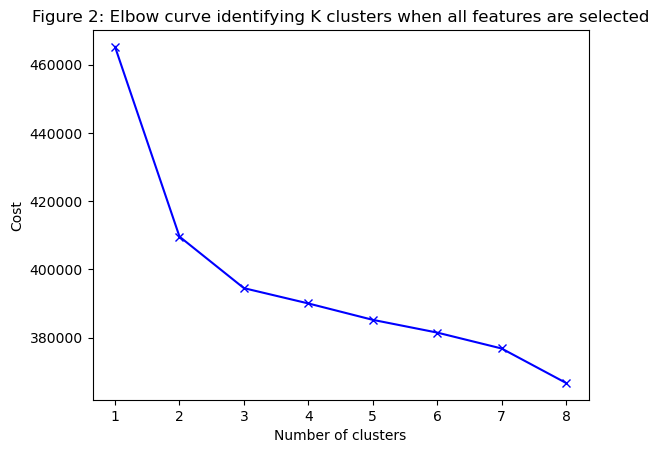

In [10]:
# ELBOW METHOD
cost = []
for num_clusters in list(range(1,9)):
  kmode = KModes(n_clusters=num_clusters, init = "Cao", n_init = 1, random_state=42, verbose=0)
  kmode.fit_predict(df)
  cost.append(kmode.cost_)
y = np.array([i for i in range(1,9)])
plt.plot(y,cost, 'bx-')
plt.xlabel("Number of clusters")
plt.ylabel("Cost")
plt.title('Figure 2: Elbow curve identifying K clusters when all features are selected')
plt.show()

The elbow curve in Figure 2 is somewhat ambiguous, but shows that the optimal number of clusters is likely to be 2. 

I ran K-modes both with 2 clusters and Cao initialisation (this means the initial cluster centers are selected by considering the distance between objects and the density of each object). The clusters chosen by the algorithm are saved as a variable. At the same time the quality of the clusters were assessed by looking at the silhouette score. 

In [ ]:
# Cluster initialisation: K=2
km = KModes(n_clusters=2, init = 'Cao', random_state = 42, verbose=0)

# Fit dataset to clustering model, save array of predicted clusters 
clusters = km.fit_predict(df)

# silhouette score
silhouette_avg = silhouette_score(df, clusters, metric='hamming')
print('Silhouette score:', silhouette_avg)

The silhouette score is close to 0, which indicates poorly defined, overlapping clusters. I decided to proceed with _k_ = 2, however, and I tried to visualise the clusters for a better insight.


In [16]:
# Create a dataframe containing cluster modes
clusterModesDf = pd.DataFrame(km.cluster_centroids_)
clusterModesDf.columns = df.columns
clusterModesDf.T

0     1
HighBP             0.0   1.0
HighChol           0.0   1.0
CholCheck          1.0   1.0
BMI                2.0   3.0
Smoker             0.0   1.0
Stroke             0.0   0.0
HeartProbs         0.0   0.0
PhysActivity       1.0   4.0
Fruits             1.0   0.0
Veggies            1.0   1.0
HvyAlcoholConsump  0.0   0.0
AnyHealthcare      1.0   1.0
NoDocbcCost        0.0   0.0
GenHlth            2.0   3.0
MentHlth           1.0   1.0
PhysHlth           1.0   1.0
DiffWalk           0.0   0.0
Sex                0.0   1.0
Age                9.0  10.0
Education          6.0   5.0
Income             8.0   7.0
MaritalStatus      1.0   1.0
Race               1.0   1.0

Here it is possible to see the mode values for each of the features. Note that a number of the features contain the same value in each cluster - CholCheck, Stroke, HeartProbs, Veggies, HvyAlcoholConsump, AnyHealthcare, NoDocbcCost, MentHlth, PhysHlth, DiffWalk, MaritalStatus, Race - which suggests that these features are not considered important criteria for clustering by the algorithm. 

It is useful to visualise the clusters to get an idea of how close and dense they are. It is necessary to use some form of dimensionality reduction to achieve this, as it's not possible to render a dataset with 23 features visually. I created a 3D plot using Multiple Correspondence Analysis (MCA), which is suited for use with categorical data. 

The following visualization implementation was adapted from code available at Visualizing High Dimensional Clusters (2018).

In [17]:
# Combining predicted clusters with original df
df['Cluster'] = clusters

In [18]:
# First initialise an MCA object with 3 components for 3D visualisation
mca_3d = prince.MCA(n_components=3)

# This DataFrame holds the three components required for 3D visualisation
comp_3d = pd.DataFrame(mca_3d.fit_transform(df.drop(["Cluster"], axis=1)))

# Create columns for the components required for 3D
comp_3d.columns = ["x_3d", "y_3d", "z_3d"]

# Add the coordinate columns to our combined dataframe
df = pd.concat([df,comp_3d], axis=1, join='inner')

# Group data points by cluster
cluster0 = df[df["Cluster"] == 0]
cluster1 = df[df["Cluster"] == 1]
cluster2 = df[df["Cluster"] == 2]

In [19]:
# 3D visualization

#trace1 is for 'Cluster 0'
trace1 = go.Scatter3d(
                    x = cluster0["x_3d"],
                    y = cluster0["y_3d"],
                    z = cluster0["z_3d"],
                    mode = "markers",
                    name = "Cluster 0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = None)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter3d(
                    x = cluster1["x_3d"],
                    y = cluster1["y_3d"],
                    z = cluster1["z_3d"],
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = None)

#trace3 is for 'Cluster 2'
trace3 = go.Scatter3d(
                    x = cluster2["x_3d"],
                    y = cluster2["y_3d"],
                    z = cluster2["z_3d"],
                    mode = "markers",
                    name = "Cluster 2",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text = None)

data = [trace1, trace2, trace3]

title = "Figure 3: Visualizing high-dimensional clusters in three dimensions using MCA"

layout = dict(title = title,
              xaxis= dict(title= 'Comp1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'Comp2',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)

Based on the results of the silhouette score obtained, I was expecting to see two overlapping clusters, and this is indeed what the plot in Figure 3 is showing. However, we must also remember that the dimensions of the data have been transformed by MCA, so the clusters we see here are not the same as the clusters obtained from K-modes. There is probably too much irrelevant or redundant data in the dataset, which makes it harder for the algorithm to find patterns and associations.

I calculated the silhouette score of the clusters obtained from MCA to see if there's any improvement from the original clusters from K-modes.

In [20]:
# Calculate silhouette score
silhouette_avg = silhouette_score(df.iloc[:, -3:], df.iloc[:, -4])
print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.16063793913156918


The silhouette score, although not great, is a slight improvement on the score obtained pre-MCA. If the original silhouette score was significantly better than the score after MCA, it could be concluded that the data just translates poorly to lower dimensions; however, both scores are very close to 0, which means that the algorithms have not found sufficient patterns in the data to create a greater separation between the clusters. It is likely that the dataset contains too much irrelevant or redundant data.

### CASE 2: Filter method
#### Steps:

*   Apply statistical methods and domain knowledge to the dataset to reduce the number of features.
*   Use elbow method to find optimal number of clusters.
*   Run K-modes on the reduced dataset.
*   Evaluate the quality of the clusters by looking at the silhouette score.

In [21]:
# Start with a fresh dataset
df = pd.read_csv('diabetes_012_health_indicators_BRFSS2015.csv')
df = df.sample(60000, random_state = 42)
df = df.drop(['Diabetes_012'],axis=1)

#### Chi-square test of independence

In [27]:
#Chi-square test of independence
# Null Hypothesis (H0): There is no relationship between the variables
# Alternative Hypothesis (H1): There is a relationship between variables

# We choose p-value = 0.05 - if the p-value test result is more than 0.05 we fail to reject the Null Hypothesis. 

# Initialize an empty DataFrame for the p-values
p_values_matrix = pd.DataFrame(index=df.columns, columns=df.columns)

# Finding p-value for all columns and putting them in the resultant matrix
for i in df.columns:
    for j in df.columns:
        if i != j:
            # Create a contingency table using value_counts
            contingency_table = pd.crosstab(df[i], df[j])

            # Perform the chi-squared test on the contingency table
            chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

            # Store the p-value in the matrix
            p_values_matrix.loc[i, j] = p_val

# Display the p-values matrix
print(p_values_matrix)

                     HighBP  HighChol CholCheck       BMI    Smoker    Stroke  \
HighBP                  NaN       0.0       0.0       0.0       0.0       0.0   
HighChol                0.0       NaN       0.0       0.0       0.0       0.0   
CholCheck               0.0       0.0       NaN       0.0  0.131127       0.0   
BMI                     0.0       0.0       0.0       NaN       0.0       0.0   
Smoker                  0.0       0.0  0.131127       0.0       NaN       0.0   
Stroke                  0.0       0.0       0.0       0.0       0.0       NaN   
HeartProbs              0.0       0.0       0.0       0.0       0.0       0.0   
PhysActivity            0.0       0.0  0.049075       0.0       0.0       0.0   
Fruits                  0.0       0.0  0.000002       0.0       0.0  0.000014   
Veggies                 0.0       0.0  0.358042       0.0       0.0       0.0   
HvyAlcoholConsump       1.0  0.017559  0.000003       0.0       0.0  0.004425   
AnyHealthcare           0.0 

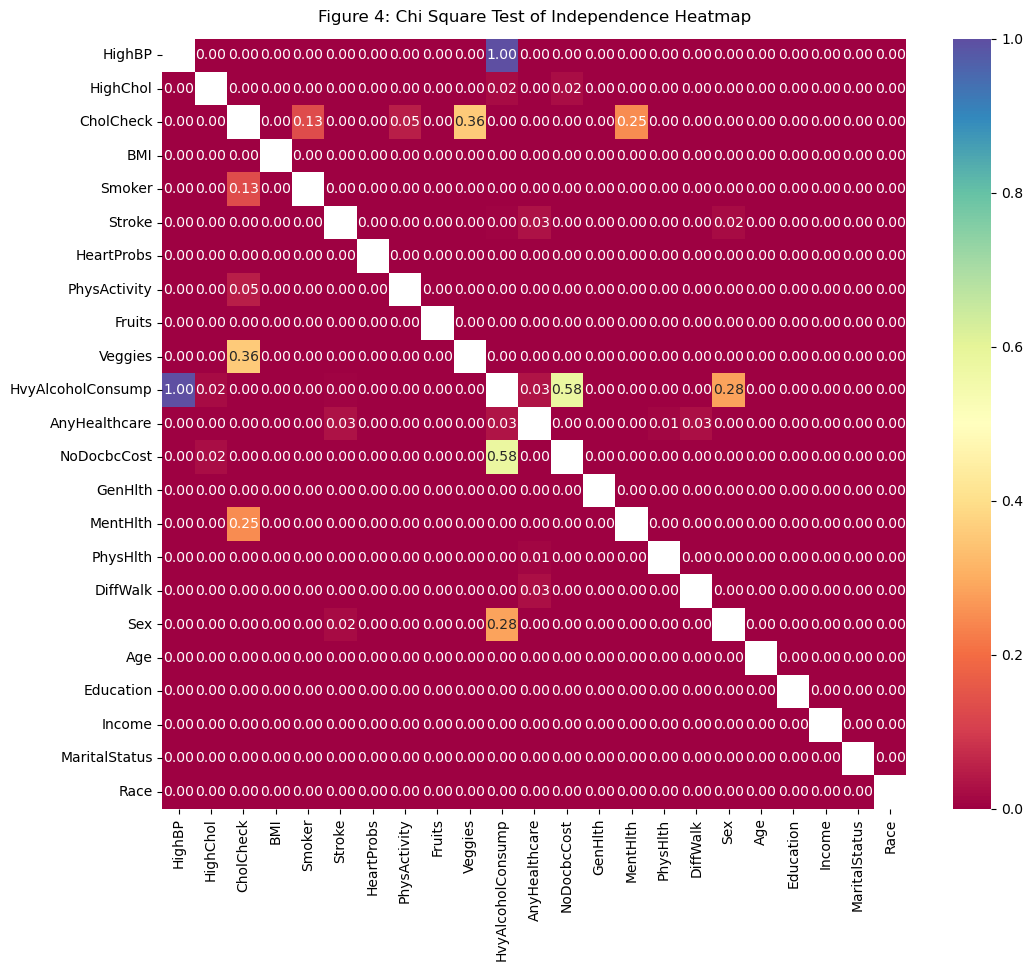

In [28]:
# Chi square heatmap
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(p_values_matrix.astype(float), xticklabels= df.columns, 
                      yticklabels= df.columns, 
                      fmt=".2f", cmap='Spectral', vmin=0, vmax=1, annot=True, center=0.5)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Figure 4: Chi Square Test of Independence Heatmap',fontdict={'fontsize':12}, pad=12);

Figure 4 is a heatmap showing the pairwise p-values between all the features in the dataset. These results are a bit surprising. A p-value of less than 0.05 means that there is evidence to reject the null hypotheses and thereby conclude that there is a relationship between the feature pair. According to the figure, almost every feature pair in the dataset are dependent, and this doesn't really help us in selecting features to include in the next test. One problem with chi-square is that it can return meaningless p-values if the size of the sample is too large, and I suspect this is what has happened here.

I decided to try another statistical method, $phi_{k}$, which is a correlation coefficient based on a refined version of the chi-square test of independence. It works equally well with nominal, ordinal and interval data, so it's suitable for use with this dataset.

In [29]:
# Create phi k correlation matrix
phik_overview = phik.phik_matrix(df, interval_cols=[])
phik_overview.round(2)

HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
HighBP               1.00      0.45       0.15  0.34    0.15    0.21   
HighChol             0.45      1.00       0.13  0.21    0.14    0.15   
CholCheck            0.15      0.13       1.00  0.06    0.01    0.04   
BMI                  0.34      0.21       0.06  1.00    0.04    0.05   
Smoker               0.15      0.14       0.01  0.04    1.00    0.11   
Stroke               0.21      0.15       0.04  0.05    0.11    1.00   
HeartProbs           0.32      0.28       0.06  0.10    0.19    0.31   
PhysActivity         0.19      0.12       0.01  0.24    0.15    0.11   
Fruits               0.06      0.07       0.03  0.13    0.12    0.03   
Veggies              0.11      0.06       0.00  0.09    0.05    0.08   
HvyAlcoholConsump    0.00      0.01       0.03  0.07    0.15    0.02   
AnyHealthcare        0.06      0.07       0.19  0.02    0.03    0.01   
NoDocbcCost          0.02      0.01       0.10  0.08    0.07    0.05   
GenHlth              0.25      0.16       0.04  0.19    0.13    0.16   
MentHlth             0.05      0.05       0.00  0.06    0.08    0.06   
PhysHlth             0.12      0.09       0.02  0.08    0.09    0.12   
DiffWalk             0.34      0.23       0.06  0.27    0.20    0.28   
Sex                  0.08      0.07       0.03  0.20    0.14    0.01   
Age                  0.37      0.31       0.10  0.14    0.16    0.14   
Education            0.21      0.09       0.02  0.11    0.25    0.12   
Income               0.24      0.11       0.03  0.14    0.18    0.17   
MaritalStatus        0.23      0.16       0.07  0.06    0.18    0.13   
Race                 0.12      0.06       0.04  0.15    0.13    0.05   

                   HeartProbs  PhysActivity  Fruits  Veggies  ...  GenHlth  \
HighBP                   0.32          0.19    0.06     0.11  ...     0.25   
HighChol                 0.28          0.12    0.07     0.06  ...     0.16   
CholCheck                0.06          0.01    0.03     0.00  ...     0.04   
BMI                      0.10          0.24    0.13     0.09  ...     0.19   
Smoker                   0.19          0.15    0.12     0.05  ...     0.13   
Stroke                   0.31          0.11    0.03     0.08  ...     0.16   
HeartProbs               1.00          0.15    0.03     0.06  ...     0.22   
PhysActivity             0.15          1.00    0.23     0.25  ...     0.20   
Fruits                   0.03          0.23    1.00     0.39  ...     0.08   
Veggies                  0.06          0.25    0.39     1.00  ...     0.10   
HvyAlcoholConsump        0.04          0.02    0.06     0.02  ...     0.03   
AnyHealthcare            0.03          0.06    0.04     0.04  ...     0.04   
NoDocbcCost              0.04          0.10    0.06     0.04  ...     0.14   
GenHlth                  0.22          0.20    0.08     0.10  ...     1.00   
MentHlth                 0.06          0.10    0.06     0.05  ...     0.43   
PhysHlth                 0.14          0.16    0.03     0.05  ...     0.68   
DiffWalk                 0.34          0.38    0.09     0.13  ...     0.41   
Sex                      0.14          0.06    0.14     0.09  ...     0.01   
Age                      0.25          0.19    0.09     0.03  ...     0.15   
Education                0.14          0.19    0.16     0.22  ...     0.22   
Income                   0.19          0.26    0.11     0.20  ...     0.31   
MaritalStatus            0.16          0.10    0.08     0.13  ...     0.13   
Race                     0.04          0.13    0.03     0.13  ...     0.12   

                   MentHlth  PhysHlth  DiffWalk   Sex   Age  Education  \
HighBP                 0.05      0.12      0.34  0.08  0.37       0.21   
HighChol               0.05      0.09      0.23  0.07  0.31       0.09   
CholCheck              0.00      0.02      0.06  0.03  0.10       0.02   
BMI                    0.06      0.08      0.27  0.20  0.14       0.11   
Smoker                 0.08      0.09      0.20

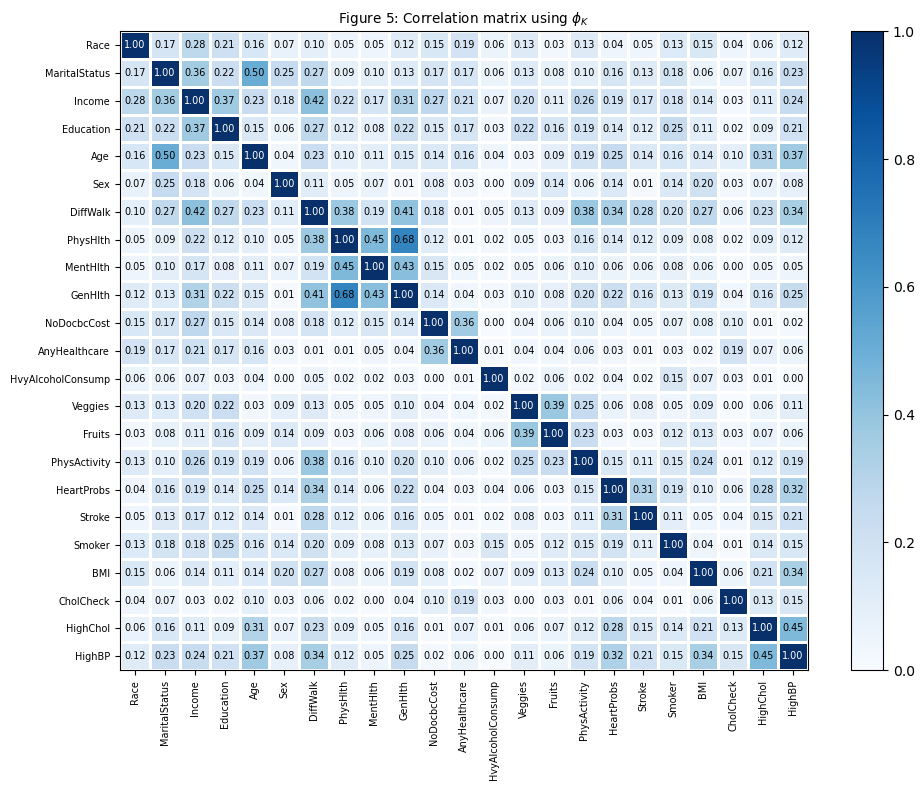

In [30]:
# Plot phi k correlation heatmap
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title=r"Figure 5: Correlation matrix using $\phi_K$", 
                        fontsize_factor=0.7, 
                        figsize=(10, 8))
plt.tight_layout()

The results of the $phi_{k}$ co-efficient analysis in Figure 5 are more helpful. A $phi_{k}$ coefficient of 0.5 or more indicates a strong association between variables, and it is possible to see this between PhysHlth and the other 'health' features (MentHlth, GenHlth and DiffWalk). In addition, there are a number of moderately strong correlations, such as between HighChol and HighBP, or between Income/MaritalStatus/Education. But it's difficult to know whether or not to drop any of these features based on this information; a correlation doesn't necessarily have to be significant. I cross-checked these correlations against a significance matrix, which will indicate if these high co-efficients are statistically significant or not.

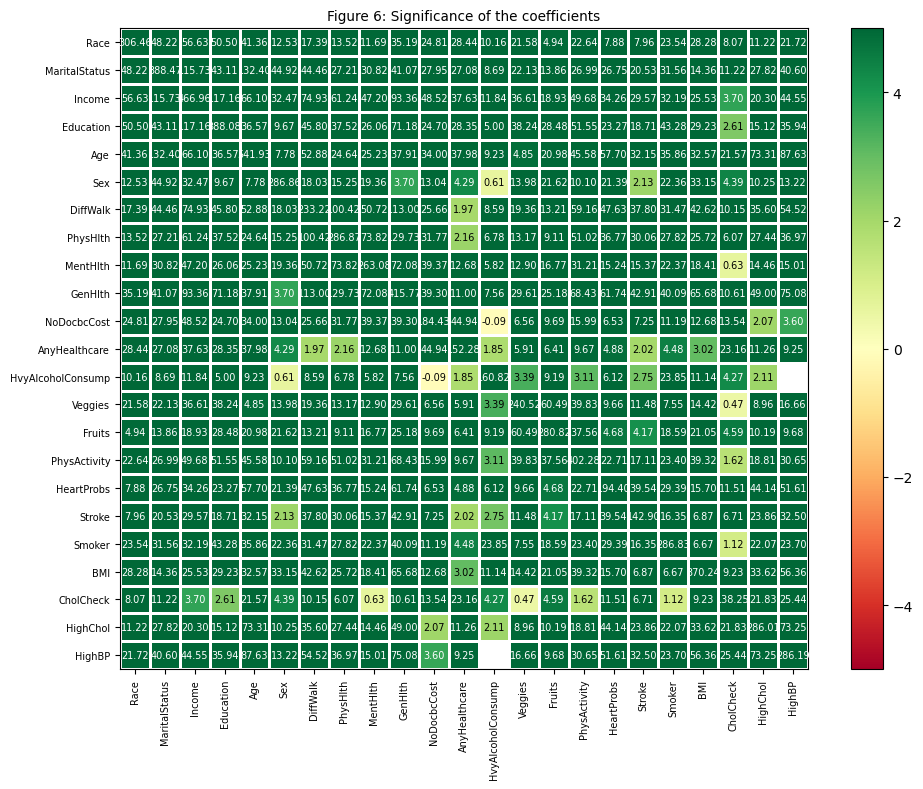

In [31]:
significance_overview = df.significance_matrix(interval_cols=[])
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title="Figure 6: Significance of the coefficients", 
                        usetex=False, fontsize_factor=0.7, figsize=(10, 8))
plt.tight_layout()

Figure 6 shows that the associations noted from Figure 5 are indeed significant. This means there are grounds to consider dropping one feature from each pair to avoid redundancy. This could be one or more of HighChol or HighBP, Fruit or Veggies, PhysHlth or GenHlth, and NoDocbcCost or AnyHealthcare.

My analysis of the bar charts (Figure 1) indicated that CholCheck, Stroke, HeartProbs, HvyAlcoholConsump, AnyHealthcare and NoDocbcCost might be good candidates to drop, and to combine values 2.0-8.0 in the Race feature to give more weighting to the non-White classes. I also noted the centroid modes from the first clustering algorithm in Case 1 that were repeated in each cluster: CholCheck, Stroke, HeartProbs, Veggies, HvyAlcoholConsump, AnyHealthcare, NoDocbcCost, MentHlth, PhysHlth, DiffWalk, MaritalStatus, Race.

After considering all these factors together, I decided to drop the following features:

CholCheck, Stroke, HeartProbs, HvyAlcoholConsump, AnyHealthcare, NoDocbcCost, Veggies, PhysHlth, MentHlth.


In [32]:
# Feature selection
df = df.drop(['CholCheck', 'Stroke','HeartProbs','HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'Veggies', 
              'PhysHlth', 'MentHlth'], axis=1)

In [107]:
# Consolidating Race feature:
# Rename White (1.0) to 0.0, as this denotes 'lower risk'
# Combine all other values into a new class, 1.0, which denotes 'higher risk'

val_map = {1.0:0.0, 2.0:1.0, 3.0:1.0, 4.0:1.0, 5.0:1.0, 6.0:1.0, 7.0:1.0, 8.0:1.0}
df['Race'] = df['Race'].replace(val_map)
print(df['Race'].value_counts())

0.0    4018
1.0     982
Name: Race, dtype: int64


I ran the elbow method once more to see if having fewer features has any impact on the optimal number of clusters.

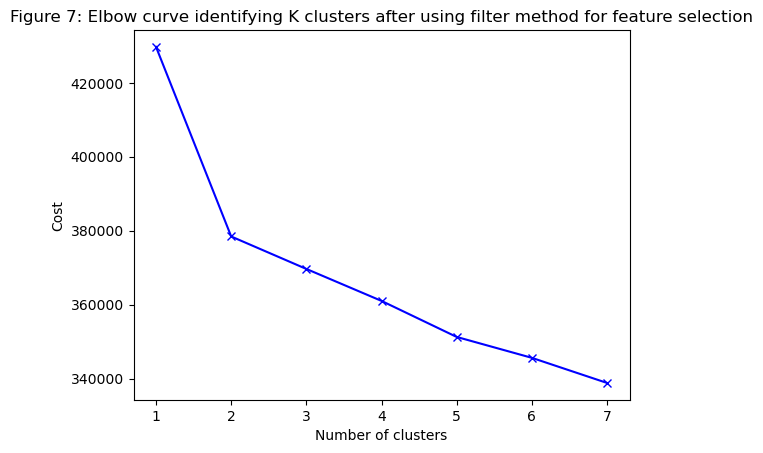

In [32]:
# ELBOW METHOD
cost = []
for num_clusters in list(range(1,8)):
  kmode = KModes(n_clusters=num_clusters, init = "Cao", random_state = 42, verbose=0)
  kmode.fit_predict(df)
  cost.append(kmode.cost_)
y = np.array([i for i in range(1,8)])
plt.plot(y,cost,'bx-')
plt.xlabel("Number of clusters")
plt.ylabel("Cost")
plt.title('Figure 7: Elbow curve identifying K clusters after using filter method for feature selection')
plt.show()


Figure 7 shows a clear 'elbow' at _k_ = 2, indicating that the optimal number of clusters is 2. I ran run K-modes and assessed the cluster quality at the same time using the silhouette score. 

In [ ]:
# Cluster initialisation
km = KModes(n_clusters=2, init = 'Cao', random_state = 42, verbose=0)

# Fit dataset to clustering model, save array of predicted clusters 
clusters = km.fit_predict(df)

# silhouette score
silhouette_avg = silhouette_score(df, clusters, metric='hamming')
print('Silhouette score:', silhouette_avg)


In this case, K-modes performed better with more data than with a subset of selected features, even though the full data likely contained redundant data. This is perhaps a little surprising, but it is evidence of the importance of using a variety of feature selection techniques to find the optimal subset which reduces dimensionality while retaining as much information as possible.

### CASE 3: Wrapper method
#### Steps:

*   Starting with the full dataset, run K-modes and find the silhouette score. This becomes the score to beat.
*   Omit the first feature in the dataset and retake the silhouette score. 
*   If the new score is the same as or better than the best score, drop the feature (as the algorithm can produce better clusters without it).
*   Repeat this process until all features in the dataset have been omitted.

I attempted to create my own version of a sequential feature selector. There are many out-of-the-box solutions which are far more advanced than this, but it gives some idea of the iterative process required. It should be noted that this algorithm has some drawbacks: It's a naive method that is unable to reevaluate a feature once it has been discarded, and it is unable to test all of the feature permutations in a large dataset. It also takes a long time to run, so for the purposes of this last case study, I further reduced the sample to 5000. Note also that I tried a different distance metric for this case; previously I had used Hamming distance, but here I used Jaccard distance.

In [9]:
# Start with a fresh dataset
df = pd.read_csv('diabetes_012_health_indicators_BRFSS2015.csv')
df = df.sample(5000, random_state = 42)
df = df.drop(['Diabetes_012'],axis=1)

In [15]:
# Cluster initialization
km = KModes(n_clusters=2, init='Huang', random_state=42, verbose=0)

# Fit dataset to clustering model, save array of predicted clusters
clusters = km.fit_predict(df)

# First silhouette score is score to beat
best_silhouette = silhouette_score(df, clusters, metric='jaccard')
print('Initial silhouette score is', best_silhouette)
# Keep track of all the discarded columns
dropped_columns = []

for column in df:
    print('Dropping', column)
    # Fit the dataset excl. the first feature and get the score
    omitted_feature = df.pop(column)
    print(df.columns)
    clusters = km.fit_predict(df)
    score = silhouette_score(df, clusters, metric='jaccard')
    print('Silhouette score without', column, ':', score)
    # If the score is worse with that feature omitted, add it back to the dataset
    # Otherwise, add the column index to the dropped column list and update the score
    if score <= best_silhouette:
        omitted_df = pd.DataFrame({omitted_feature.name: omitted_feature})
        df = pd.concat([df, omitted_df], axis=1)
    else:
        dropped_columns.append(column)
        best_silhouette = score
        print('Dropped:', dropped_columns)
       
print('\nBest silhouette score is', best_silhouette)
print('Dropped:', dropped_columns)

C:\Users\emmah\anaconda3\Lib\site-packages\sklearn\metrics\pairwise.py:2181: DataConversionWarning:

Data was converted to boolean for metric jaccard



Initial silhouette score is 0.1668028970791909
Dropping HighBP
Index(['HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartProbs',
       'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump',
       'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth',
       'DiffWalk', 'Sex', 'Age', 'Education', 'Income', 'MaritalStatus',
       'Race'],
      dtype='object')


C:\Users\emmah\anaconda3\Lib\site-packages\sklearn\metrics\pairwise.py:2181: DataConversionWarning:

Data was converted to boolean for metric jaccard



Silhouette score without HighBP : 0.16265359524237066
Dropping HighChol
Index(['CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartProbs', 'PhysActivity',
       'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare',
       'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex',
       'Age', 'Education', 'Income', 'MaritalStatus', 'Race', 'HighBP'],
      dtype='object')


C:\Users\emmah\anaconda3\Lib\site-packages\sklearn\metrics\pairwise.py:2181: DataConversionWarning:

Data was converted to boolean for metric jaccard



Silhouette score without HighChol : 0.16958160893648674
Dropped: ['HighChol']
Dropping CholCheck
Index(['BMI', 'Smoker', 'Stroke', 'HeartProbs', 'PhysActivity', 'Fruits',
       'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost',
       'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age',
       'Education', 'Income', 'MaritalStatus', 'Race', 'HighBP'],
      dtype='object')


C:\Users\emmah\anaconda3\Lib\site-packages\sklearn\metrics\pairwise.py:2181: DataConversionWarning:

Data was converted to boolean for metric jaccard



Silhouette score without CholCheck : 0.1678629091891287
Dropping BMI
Index(['Smoker', 'Stroke', 'HeartProbs', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income',
       'MaritalStatus', 'Race', 'HighBP', 'CholCheck'],
      dtype='object')


C:\Users\emmah\anaconda3\Lib\site-packages\sklearn\metrics\pairwise.py:2181: DataConversionWarning:

Data was converted to boolean for metric jaccard



Silhouette score without BMI : 0.18471864889235498
Dropped: ['HighChol', 'BMI']
Dropping Smoker
Index(['Stroke', 'HeartProbs', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income',
       'MaritalStatus', 'Race', 'HighBP', 'CholCheck'],
      dtype='object')


C:\Users\emmah\anaconda3\Lib\site-packages\sklearn\metrics\pairwise.py:2181: DataConversionWarning:

Data was converted to boolean for metric jaccard



Silhouette score without Smoker : 0.18464102798397217
Dropping Stroke
Index(['HeartProbs', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump',
       'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth',
       'DiffWalk', 'Sex', 'Age', 'Education', 'Income', 'MaritalStatus',
       'Race', 'HighBP', 'CholCheck', 'Smoker'],
      dtype='object')


C:\Users\emmah\anaconda3\Lib\site-packages\sklearn\metrics\pairwise.py:2181: DataConversionWarning:

Data was converted to boolean for metric jaccard



Silhouette score without Stroke : 0.18452604334227407
Dropping HeartProbs
Index(['PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump',
       'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth',
       'DiffWalk', 'Sex', 'Age', 'Education', 'Income', 'MaritalStatus',
       'Race', 'HighBP', 'CholCheck', 'Smoker', 'Stroke'],
      dtype='object')


C:\Users\emmah\anaconda3\Lib\site-packages\sklearn\metrics\pairwise.py:2181: DataConversionWarning:

Data was converted to boolean for metric jaccard



Silhouette score without HeartProbs : 0.17103401193362228
Dropping PhysActivity
Index(['Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare',
       'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex',
       'Age', 'Education', 'Income', 'MaritalStatus', 'Race', 'HighBP',
       'CholCheck', 'Smoker', 'Stroke', 'HeartProbs'],
      dtype='object')


C:\Users\emmah\anaconda3\Lib\site-packages\sklearn\metrics\pairwise.py:2181: DataConversionWarning:

Data was converted to boolean for metric jaccard



Silhouette score without PhysActivity : 0.19784434721749303
Dropped: ['HighChol', 'BMI', 'PhysActivity']
Dropping Fruits
Index(['Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost',
       'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age',
       'Education', 'Income', 'MaritalStatus', 'Race', 'HighBP', 'CholCheck',
       'Smoker', 'Stroke', 'HeartProbs'],
      dtype='object')


C:\Users\emmah\anaconda3\Lib\site-packages\sklearn\metrics\pairwise.py:2181: DataConversionWarning:

Data was converted to boolean for metric jaccard



Silhouette score without Fruits : 0.2075168241005384
Dropped: ['HighChol', 'BMI', 'PhysActivity', 'Fruits']
Dropping Veggies
Index(['HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income',
       'MaritalStatus', 'Race', 'HighBP', 'CholCheck', 'Smoker', 'Stroke',
       'HeartProbs'],
      dtype='object')


C:\Users\emmah\anaconda3\Lib\site-packages\sklearn\metrics\pairwise.py:2181: DataConversionWarning:

Data was converted to boolean for metric jaccard



Silhouette score without Veggies : 0.24993703976711068
Dropped: ['HighChol', 'BMI', 'PhysActivity', 'Fruits', 'Veggies']
Dropping HvyAlcoholConsump
Index(['AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth',
       'DiffWalk', 'Sex', 'Age', 'Education', 'Income', 'MaritalStatus',
       'Race', 'HighBP', 'CholCheck', 'Smoker', 'Stroke', 'HeartProbs'],
      dtype='object')


C:\Users\emmah\anaconda3\Lib\site-packages\sklearn\metrics\pairwise.py:2181: DataConversionWarning:

Data was converted to boolean for metric jaccard



Silhouette score without HvyAlcoholConsump : 0.258876218291402
Dropped: ['HighChol', 'BMI', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump']
Dropping AnyHealthcare
Index(['NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex',
       'Age', 'Education', 'Income', 'MaritalStatus', 'Race', 'HighBP',
       'CholCheck', 'Smoker', 'Stroke', 'HeartProbs'],
      dtype='object')


C:\Users\emmah\anaconda3\Lib\site-packages\sklearn\metrics\pairwise.py:2181: DataConversionWarning:

Data was converted to boolean for metric jaccard



Silhouette score without AnyHealthcare : 0.2362299963675879
Dropping NoDocbcCost
Index(['GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age',
       'Education', 'Income', 'MaritalStatus', 'Race', 'HighBP', 'CholCheck',
       'Smoker', 'Stroke', 'HeartProbs', 'AnyHealthcare'],
      dtype='object')


C:\Users\emmah\anaconda3\Lib\site-packages\sklearn\metrics\pairwise.py:2181: DataConversionWarning:

Data was converted to boolean for metric jaccard



Silhouette score without NoDocbcCost : 0.22309228517447055
Dropping GenHlth
Index(['MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income',
       'MaritalStatus', 'Race', 'HighBP', 'CholCheck', 'Smoker', 'Stroke',
       'HeartProbs', 'AnyHealthcare', 'NoDocbcCost'],
      dtype='object')


C:\Users\emmah\anaconda3\Lib\site-packages\sklearn\metrics\pairwise.py:2181: DataConversionWarning:

Data was converted to boolean for metric jaccard



Silhouette score without GenHlth : 0.25108313006876465
Dropping MentHlth
Index(['PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income',
       'MaritalStatus', 'Race', 'HighBP', 'CholCheck', 'Smoker', 'Stroke',
       'HeartProbs', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth'],
      dtype='object')


C:\Users\emmah\anaconda3\Lib\site-packages\sklearn\metrics\pairwise.py:2181: DataConversionWarning:

Data was converted to boolean for metric jaccard



Silhouette score without MentHlth : 0.22829839084481574
Dropping PhysHlth
Index(['DiffWalk', 'Sex', 'Age', 'Education', 'Income', 'MaritalStatus',
       'Race', 'HighBP', 'CholCheck', 'Smoker', 'Stroke', 'HeartProbs',
       'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth'],
      dtype='object')


C:\Users\emmah\anaconda3\Lib\site-packages\sklearn\metrics\pairwise.py:2181: DataConversionWarning:

Data was converted to boolean for metric jaccard



Silhouette score without PhysHlth : 0.22829839084481574
Dropping DiffWalk
Index(['Sex', 'Age', 'Education', 'Income', 'MaritalStatus', 'Race', 'HighBP',
       'CholCheck', 'Smoker', 'Stroke', 'HeartProbs', 'AnyHealthcare',
       'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth'],
      dtype='object')


C:\Users\emmah\anaconda3\Lib\site-packages\sklearn\metrics\pairwise.py:2181: DataConversionWarning:

Data was converted to boolean for metric jaccard



Silhouette score without DiffWalk : 0.2516865418129648
Dropping Sex
Index(['Age', 'Education', 'Income', 'MaritalStatus', 'Race', 'HighBP',
       'CholCheck', 'Smoker', 'Stroke', 'HeartProbs', 'AnyHealthcare',
       'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk'],
      dtype='object')


C:\Users\emmah\anaconda3\Lib\site-packages\sklearn\metrics\pairwise.py:2181: DataConversionWarning:

Data was converted to boolean for metric jaccard



Silhouette score without Sex : 0.24258252440183017
Dropping Age
Index(['Education', 'Income', 'MaritalStatus', 'Race', 'HighBP', 'CholCheck',
       'Smoker', 'Stroke', 'HeartProbs', 'AnyHealthcare', 'NoDocbcCost',
       'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex'],
      dtype='object')


C:\Users\emmah\anaconda3\Lib\site-packages\sklearn\metrics\pairwise.py:2181: DataConversionWarning:

Data was converted to boolean for metric jaccard



Silhouette score without Age : 0.24192562312164728
Dropping Education
Index(['Income', 'MaritalStatus', 'Race', 'HighBP', 'CholCheck', 'Smoker',
       'Stroke', 'HeartProbs', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age'],
      dtype='object')


C:\Users\emmah\anaconda3\Lib\site-packages\sklearn\metrics\pairwise.py:2181: DataConversionWarning:

Data was converted to boolean for metric jaccard



Silhouette score without Education : 0.2535100507856829
Dropping Income
Index(['MaritalStatus', 'Race', 'HighBP', 'CholCheck', 'Smoker', 'Stroke',
       'HeartProbs', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth',
       'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education'],
      dtype='object')


C:\Users\emmah\anaconda3\Lib\site-packages\sklearn\metrics\pairwise.py:2181: DataConversionWarning:

Data was converted to boolean for metric jaccard



Silhouette score without Income : 0.22846964352858976
Dropping MaritalStatus
Index(['Race', 'HighBP', 'CholCheck', 'Smoker', 'Stroke', 'HeartProbs',
       'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth',
       'DiffWalk', 'Sex', 'Age', 'Education', 'Income'],
      dtype='object')


C:\Users\emmah\anaconda3\Lib\site-packages\sklearn\metrics\pairwise.py:2181: DataConversionWarning:

Data was converted to boolean for metric jaccard



Silhouette score without MaritalStatus : 0.2535100507856829
Dropping Race
Index(['HighBP', 'CholCheck', 'Smoker', 'Stroke', 'HeartProbs',
       'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth',
       'DiffWalk', 'Sex', 'Age', 'Education', 'Income', 'MaritalStatus'],
      dtype='object')


C:\Users\emmah\anaconda3\Lib\site-packages\sklearn\metrics\pairwise.py:2181: DataConversionWarning:

Data was converted to boolean for metric jaccard



Silhouette score without Race : 0.18317637926377672

Best silhouette score is 0.258876218291402
Dropped: ['HighChol', 'BMI', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump']


Although 0.16269698974440922 is not a good silhouette score, this method performs better than using the full dataset, using MCA on the full dataset, and the filter method. A more advanced version of this wrapper method has the potential to find the best possible subset of our dataset. Of course, K-modes can only work with the data it has been given, so if different wrapper methods all resulted in a silhouette score of under 0.2, we would have to accept that our data is insufficient to make any conclusions about the nature of the clusters.

## Conclusion 

Is it possible to take subjective data from a survey and use it to accurately predict if an individual is diabetic, prediabetic or non-diabetic? If there is no ground truth, it becomes a much harder task; unsupervised learning, such as clustering, does not offer clear-cut answers, but instead can offer insight into previously unknown patterns or connections between observations. 

While I did not have time to explore all the various methods that were available to us, I took a large dataset of categorical data, performed data exploration and statistical analysis, and looked at the impact of feature selection on the quality of the clustering. 

The improvements made were negligible, and I suspect that much of this comes down to the raw data I was working with. The BRFSS survey is a general health-related survey, and as such is missing much of the diabetes-specific data that could contributed positively to clustering, such as:

*  Information about diabetes in the family, as we know there is a strong genetic component to developing both types of diabetes.
*  Smoking was limited to a simple yes/no answer, but it may have been helpful to have had quantitative data here regarding amount of cigarettes smoked or length of time a person has been a smoker.
*  The only data about diet related to whether a respondent ate fruit and vegetables, and there is much more to a healthy diet than that - it would have been good to have had data on ready meals, takeaways, salt intake, etc.

Although I was hoping to be able to distinguish diabetes from prediabetes and no diabetes, all of the silhouette analyses showed that the optimal number of clusters was two. This is not really surprising: Prediabetes is a precursor to diabetes and the two conditions are distinguished only by blood sugar level; the subtle physiological differences would be hard for a patient to pick up, so their survey responses are likely to be very similar. As long as the algorithm groups prediabetics together with diabetics, the model can still be useful, as then it would ensure that all individuals with or at risk of developing diabetes are identified. However, it is extremely important to remember that two or three well-defined clusters does not necessarily translate to a cluster for each diabetes category; all this tells us is that the algorithm has found sufficient similarity between two or three sets of data points to be able to place them together, while separating them from other clusters. We don't yet know what criteria the algorithm has used to make these decisions. In order to make any inferences about the characteristics of each cluster, I would have to perform further in-depth analysis.

I gained two important takeaways from this project:  

*  Every decision made during the course of an investigation - from selecting the dataset through to choosing evaluation metrics - has the potential to influence the quality of the clusters and therefore the results of the model. This reinforced to me the importance of carefully considering each aspect of the methodology in light of the research question and the project goal. 

*  Producing clusters is but one stage in a much broader process - cluster analysis is essential to making sense of the data. Cluster evaluation (by measuring silhouette scores, for example) is not sufficient to draw meaningful conclusions about the clusters. A higher silhouette score does not necessarily mean you are closer to reaching your goal!

## Future work

The clustering process involves many variables and parameters; this is positive, as it means there are many different settings I can explore to try to improve the results of my investigation:  

*  There are several clustering algorithms to try:
  *  K-Prototypes (if I retain the mixed datatypes from the original dataset).
  *  DBSCAN, spectral clustering and neural networks can be adapted to work with categorical data.
*  There are different methods of encoding categorical features (e.g. OHE for low cardinality features).
*  The wrapper method was the most successful for my project; I could look at other wrapper methods such as Recursive Feature Elimination or perhaps use an in-built feature selection library.
*  There are many hyperparameters to fine-tune (e.g. cluster initialisations, distance metrics, similarity measures).
*  Finally, perhaps I need to consider a different evaluation metric for assessing cluster quality (e.g. Davis-Bouldin Index).

## References

About BRFSS. (n.d.). CDC. Retrieved November 08, 2023, from https://www.cdc.gov/brfss/about/index.htm

BRFSS 2015 Codebook Report. (2016, August 23). CDC. Retrieved November 30, 2023, from https://www.cdc.gov/brfss/annual_data/2015/pdf/codebook15_llcp.pdf

Diabetes Health Indicators Dataset. (2023, June 16). kaggle. Retrieved November 30, 2023, from https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset/data

Diabetes Health Indicators Dataset Notebook. (2023, June 16). kaggle. Retrieved November 30, 2023, from https://www.kaggle.com/code/hakonem/diabetes-health-indicators-dataset-notebook/notebook

Diabetes Risk Factors. (n.d.). CDC. Retrieved November 30, 2023, from https://www.cdc.gov/diabetes/basics/risk-factors.html

Ford, K.J., & Robitaille, A. How sweet is your love? Disentangling the role of marital status and quality on average glycemic levels among adults 50 years and older in the English Longitudinal Study of Ageing. (2023, June 16). *BMJ Open Diabetes Research and Care*. Retrieved November 30, 2023, from https://drc.bmj.com/content/11/1/e003080

Guide, S., & Bonthu, H. (2023, September 14). KModes Clustering Algorithm for Categorical data. Analytics Vidhya. Retrieved November 30, 2023, from https://www.analyticsvidhya.com/blog/2021/06/kmodes-clustering-algorithm-for-categorical-data/#89b0

Jain, A. (2020, July 17). Learn how to do Feature Selection the Right way. Towards Data Science. Retrieved November 30, 2023, from https://towardsdatascience.com/learn-how-to-do-feature-selection-the-right-way-61bca8557bef

Jain, S. (2023). Elbow Method for Optimal Value of K in KMeans. GeeksforGeeks. Retrieved November 30, 2023, from https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

Joshi, T. (2021, March 21). Evaluating Clustering Algorithm — Silhouette Score | by Tushar Joshi | Medium. Tushar Joshi. Retrieved November 30, 2023, from https://tushar-joshi-89.medium.com/silhouette-score-a9f7d8d78f29

Khoong, W. H. (2023, June 15). Dimensionality Reduction Techniques For Categorical & Continuous Data. Medium. Retrieved November 30, 2023, from https://medium.com/codex/dimensionality-reduction-techniques-for-categorical-continuous-data-75d2bca53100

Lewinson, E. (2021, August 9). Phik (𝜙k) — get familiar with the latest correlation coefficient. Towards Data Science. Retrieved November 30, 2023, from https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7#:~:text=Phik%20(%20%F0%9D%9C%99%20k)%20is%20a,a%20bivariate%20normal%20input%20distribution

Multiple Correspondence Analysis. (n.d.). The University of Texas at Dallas. Retrieved November 30, 2023, from https://personal.utdallas.edu/~herve/Abdi-MCA2007-pretty.pdf

National Diabetes Statistics Report. (2023, June 16). cdc.gov. Retrieved November 30, 2023, from https://www.cdc.gov/diabetes/data/statistics-report/index.html?CDC_AA_refVal=https%3A%2F%2Fwww.cdc.gov%2Fdiabetes%2Fdata%2Fstatistics-report%2Fdiagnosed-diabetes.html

Symptoms & Causes of Diabetes - NIDDK. (n.d.). National Institute of Diabetes and Digestive and Kidney Diseases. Retrieved November 30, 2023, from https://www.niddk.nih.gov/health-information/diabetes/overview/symptoms-causes

Visualizing High Dimensional Clusters. (2018). kaggle. Retrieved November 30, 2023, from https://www.kaggle.com/code/minc33/visualizing-high-dimensional-clusters
